# KuaiRec Dataset Exploration

## Theoretical Framework: Complex Networks & Data-Driven Modeling

This notebook explores the KuaiRec dataset through the lens of **complex networks theory** and **data-driven modeling**.

### Two Core Approaches 

#### 1. Network Characterization
**Goal**: Understand the structure and properties of networks

**Key Concepts**:
- **Degree Distribution**: How many connections does each node have? In social networks, most people have few friends, but some have many (power-law distribution)
- **Clustering**: Do friends of your friends tend to be your friends? (Triangles in the network)
- **Path Lengths**: How many steps to get from one user to another?
- **Centrality**: Who are the most important/influential nodes?
  - *Degree centrality*: Simply how many connections
  - *Betweenness centrality*: How often a node lies on shortest paths between others
  - *Eigenvector centrality*: Being connected to important nodes makes you important
- **Community Detection**: Are there clusters of tightly connected users?

**Why this matters for KuaiRec**: The social network structure can influence what videos people watch. Users connected to many others might spread content faster (diffusion).

#### 2. Data-Driven Modeling
**Goal**: Build predictive models based on data patterns

**Key Concepts**:
- **Regression Models**: Predict a continuous outcome (e.g., watch time) from features
  - *LASSO regression*: Automatically selects important features by pushing irrelevant coefficients to zero
  - *Ridge regression*: Prevents overfitting by penalizing large coefficients
- **Feature Engineering**: Creating informative variables from raw data
  - Network features: degree, centrality, clustering coefficient of each user
  - Content features: video tags, duration, popularity
  - Temporal features: time of day, day of week
- **Model Interpretation**: What factors actually drive behavior?

**Why this matters for KuaiRec**: We want to understand what predicts watch time - is it the user's social position? Video popularity? Content type?

---

## Our Research Question

**Primary Focus**: What factors influence user watch time and engagement patterns?

We'll combine both approaches:
1. **Network Characterization**: Analyze the social network structure
2. **Data-Driven Modeling**: Build predictive models using network features + content features

---

## Setup

In [30]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Network analysis
import networkx as nx

# Machine learning
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

%matplotlib inline

## 1. Data Loading

The KuaiRec dataset contains:
- **User-item interaction matrix**: Which users watched which videos and for how long
- **Social network**: Follower relationships between users
- **Video features**: Content tags, duration, popularity metrics
- **User features**: Demographics, activity levels

In [31]:
# Load KuaiRec dataset
print("Loading KuaiRec dataset...")

# Start with small_matrix for faster initial exploration
# Switch to big_matrix once you're ready for full analysis
interactions = pd.read_csv('../data/raw/small_matrix.csv')
print(f"✓ Loaded interactions: {interactions.shape[0]:,} rows, {interactions.shape[1]} columns")

# Social network (friend connections)
social_network = pd.read_csv('../data/raw/social_network.csv')
print(f"✓ Loaded social network: {social_network.shape[0]:,} users")

# Video features (categories/tags)
video_features = pd.read_csv('../data/raw/item_categories.csv')
print(f"✓ Loaded video features: {video_features.shape[0]:,} videos")

# User features (demographics, activity levels)
user_features = pd.read_csv('../data/raw/user_features.csv')
print(f"✓ Loaded user features: {user_features.shape[0]:,} users")

print("\n" + "="*60)
print("Dataset Overview")
print("="*60)
print(f"Total interactions: {interactions.shape[0]:,}")
print(f"Unique users: {interactions['user_id'].nunique():,}")
print(f"Unique videos: {interactions['video_id'].nunique():,}")
print(f"Date range: {interactions['date'].min()} to {interactions['date'].max()}")

# Display sample of interaction data
print("\nSample interaction data:")
print(interactions.head())

print("\nInteraction columns:")
print(interactions.columns.tolist())

print("\nUser feature columns:")
print(user_features.columns.tolist())

Loading KuaiRec dataset...
✓ Loaded interactions: 4,676,570 rows, 8 columns
✓ Loaded social network: 472 users
✓ Loaded video features: 10,728 videos
✓ Loaded user features: 7,176 users

Dataset Overview
Total interactions: 4,676,570
Unique users: 1,411
Unique videos: 3,327
Date range: 20200705.0 to 20200905.0

Sample interaction data:
   user_id  video_id  play_duration  video_duration                     time  \
0       14       148           4381            6067  2020-07-05 05:27:48.378   
1       14       183          11635            6100  2020-07-05 05:28:00.057   
2       14      3649          22422           10867  2020-07-05 05:29:09.479   
3       14      5262           4479            7908  2020-07-05 05:30:43.285   
4       14      8234           4602           11000  2020-07-05 05:35:43.459   

         date     timestamp  watch_ratio  
0  20200705.0  1.593898e+09     0.722103  
1  20200705.0  1.593898e+09     1.907377  
2  20200705.0  1.593898e+09     2.063311  
3  202007

## 2. Network Characterization

### Theory: Why Analyze the Social Network?

**Social influence hypothesis**: People's behavior (including video watching) is influenced by their social connections.

**Key questions**:
- Do central users watch more content?
- Do users in dense communities have similar watch patterns?
- How does content diffuse through the network?

### Network Metrics to Compute

1. **Basic Statistics**
   - Number of nodes (users) and edges (connections)
   - Degree distribution
   - Density: How connected is the network?

2. **Structural Properties**
   - Clustering coefficient: Do friends cluster together?
   - Average path length: How many hops between users?
   - Connected components: Is the network fragmented?

3. **Centrality Measures** (for each user)
   - Degree: Number of connections
   - Betweenness: Bridge between communities
   - Eigenvector: Connected to important people
   - PageRank: Like Google's algorithm for web pages

Building social network graph...
Total edges extracted: 670

Network Statistics:
  Number of users (nodes): 472
  Number of connections (edges): 670
  Network density: 0.003014
  Is weakly connected: False
  Connected components: 192
  Largest component size: 8 nodes (1.7%)

Degree Statistics:
  Mean degree: 2.84
  Median degree: 2
  Max degree: 10
  Min degree: 2


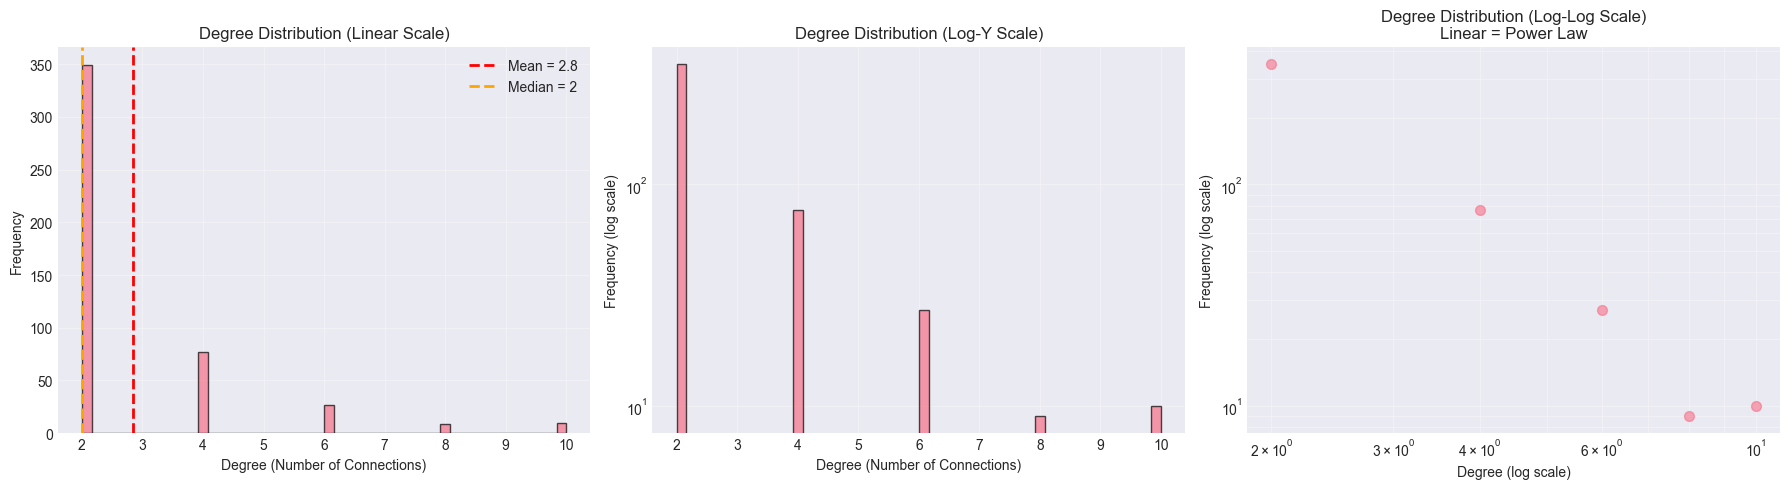


Interpretation:
If the log-log plot shows a roughly linear trend, the network
follows a power-law (scale-free) distribution - common in social networks.
This means: few highly connected 'hubs', many low-degree nodes.


In [32]:
# Build network from social connections
print("Building social network graph...")

# Parse friend_list (stored as string representation of list)
import ast

edges = []
for _, row in social_network.iterrows():
    user_id = row['user_id']
    friend_list = ast.literal_eval(row['friend_list'])
    for friend_id in friend_list:
        edges.append((user_id, friend_id))

print(f"Total edges extracted: {len(edges):,}")

# Create directed graph (following relationships)
G = nx.DiGraph()
G.add_edges_from(edges)

print(f"\n{'='*60}")
print("Network Statistics:")
print('='*60)
print(f"  Number of users (nodes): {G.number_of_nodes():,}")
print(f"  Number of connections (edges): {G.number_of_edges():,}")
print(f"  Network density: {nx.density(G):.6f}")
print(f"  Is weakly connected: {nx.is_weakly_connected(G)}")

# For undirected metrics, create undirected version
G_undirected = G.to_undirected()
num_components = nx.number_connected_components(G_undirected)
print(f"  Connected components: {num_components}")

# Find largest component
largest_cc = max(nx.connected_components(G_undirected), key=len)
print(f"  Largest component size: {len(largest_cc)} nodes ({100*len(largest_cc)/G.number_of_nodes():.1f}%)")

# Degree distribution
degrees = dict(G.degree())
degree_values = list(degrees.values())

# Calculate degree statistics
print(f"\n{'='*60}")
print("Degree Statistics:")
print('='*60)
print(f"  Mean degree: {np.mean(degree_values):.2f}")
print(f"  Median degree: {np.median(degree_values):.0f}")
print(f"  Max degree: {np.max(degree_values)}")
print(f"  Min degree: {np.min(degree_values)}")

# Plot degree distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Linear scale
axes[0].hist(degree_values, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Degree (Number of Connections)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Degree Distribution (Linear Scale)')
axes[0].axvline(np.mean(degree_values), color='red', linestyle='--', 
                linewidth=2, label=f'Mean = {np.mean(degree_values):.1f}')
axes[0].axvline(np.median(degree_values), color='orange', linestyle='--', 
                linewidth=2, label=f'Median = {np.median(degree_values):.0f}')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Log-y scale
axes[1].hist(degree_values, bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Degree (Number of Connections)')
axes[1].set_ylabel('Frequency (log scale)')
axes[1].set_title('Degree Distribution (Log-Y Scale)')
axes[1].set_yscale('log')
axes[1].grid(alpha=0.3)

# Log-log scale (to check for power law)
# Use histogram with more bins for better power law visualization
degree_counts = np.bincount(degree_values)
degrees_unique = np.arange(len(degree_counts))
mask = degree_counts > 0  # Only plot non-zero counts

axes[2].scatter(degrees_unique[mask], degree_counts[mask], alpha=0.6, s=50)
axes[2].set_xlabel('Degree (log scale)')
axes[2].set_ylabel('Frequency (log scale)')
axes[2].set_title('Degree Distribution (Log-Log Scale)\nLinear = Power Law')
axes[2].set_yscale('log')
axes[2].set_xscale('log')
axes[2].grid(alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print("Interpretation:")
print('='*60)
print("If the log-log plot shows a roughly linear trend, the network")
print("follows a power-law (scale-free) distribution - common in social networks.")
print("This means: few highly connected 'hubs', many low-degree nodes.")

### Interpretation Guide

**What to look for in degree distribution**:
- **Power-law degree distribution**: A few highly connected users (influencers), many with few connections
- **High clustering**: Indicates community structure
- **Small world property**: Short average path length despite large network size

**Scale-free networks**: If degree follows power law P(k) ~ k^(-γ), the network is scale-free (common in social networks)

---

### Understanding Centrality Metrics

The centrality measures we compute capture different aspects of "importance" in the network:

#### 1. Degree Centrality
**What it measures**: Simply the fraction of nodes a user is connected to

**Formula**: degree_centrality(node) = degree(node) / (N - 1)

**Interpretation**: 
- High degree centrality = "popular" or "social" users with many connections
- In directed graphs: considers both in-degree (followers) and out-degree (following)
- Range: [0, 1] where 1 = connected to everyone

**Social network meaning**: Users with high degree centrality are well-connected and can potentially reach many others directly

#### 2. PageRank
**What it measures**: Importance based on the importance of your connections (Google's algorithm)

**Key idea**: Being followed by important people makes you important

**Formula**: Recursive - your PageRank depends on the PageRank of nodes pointing to you

**Interpretation**:
- Higher PageRank = more influential position in the network
- Considers both quantity and quality of connections
- Like "prestige" or "authority" in the network

**Social network meaning**: Users with high PageRank are influential - they're connected to other influential users

#### 3. Betweenness Centrality
**What it measures**: How often a node lies on shortest paths between other nodes

**Formula**: Fraction of all shortest paths that pass through a given node

**Interpretation**:
- High betweenness = "bridge" or "broker" between different parts of the network
- These users control information flow
- Range: [0, 1] where higher = more bridging

**Social network meaning**: Users with high betweenness connect different communities - removing them would fragment the network

#### 4. Clustering Coefficient
**What it measures**: How much your neighbors are connected to each other

**Formula**: (# of triangles involving node) / (# of possible triangles)

**Interpretation**:
- High clustering (near 1) = your friends are friends with each other
- Low clustering (near 0) = your friends don't know each other
- Indicates how "cliquish" someone's neighborhood is

**Social network meaning**: High clustering suggests tight-knit communities; low suggests bridging across groups

---

### How These Relate to Watch Behavior

**Hypothesis testing**:
- **High degree** → More exposure to content through social feeds?
- **High PageRank** → Trendsetting behavior? Watch videos that later become popular?
- **High betweenness** → Diverse viewing patterns from bridging communities?
- **High clustering** → Similar viewing to friend group due to tight community?

We'll test these hypotheses in the modeling section!

Computing centrality measures...
(This may take a minute for larger networks)
✓ Degree centrality computed
✓ PageRank computed
✓ Betweenness centrality computed (exact)
✓ Clustering coefficient computed

Network features created for 472 users

Sample network features:
   user_id  degree_centrality  betweenness_centrality  pagerank  \
0     3371           0.004246                0.000000  0.001630   
1     2975           0.008493                0.000009  0.003097   
2       24           0.004246                0.000000  0.002119   
3     2665           0.004246                0.000000  0.002119   
4     4402           0.004246                0.000000  0.001049   

   clustering_coef  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0  


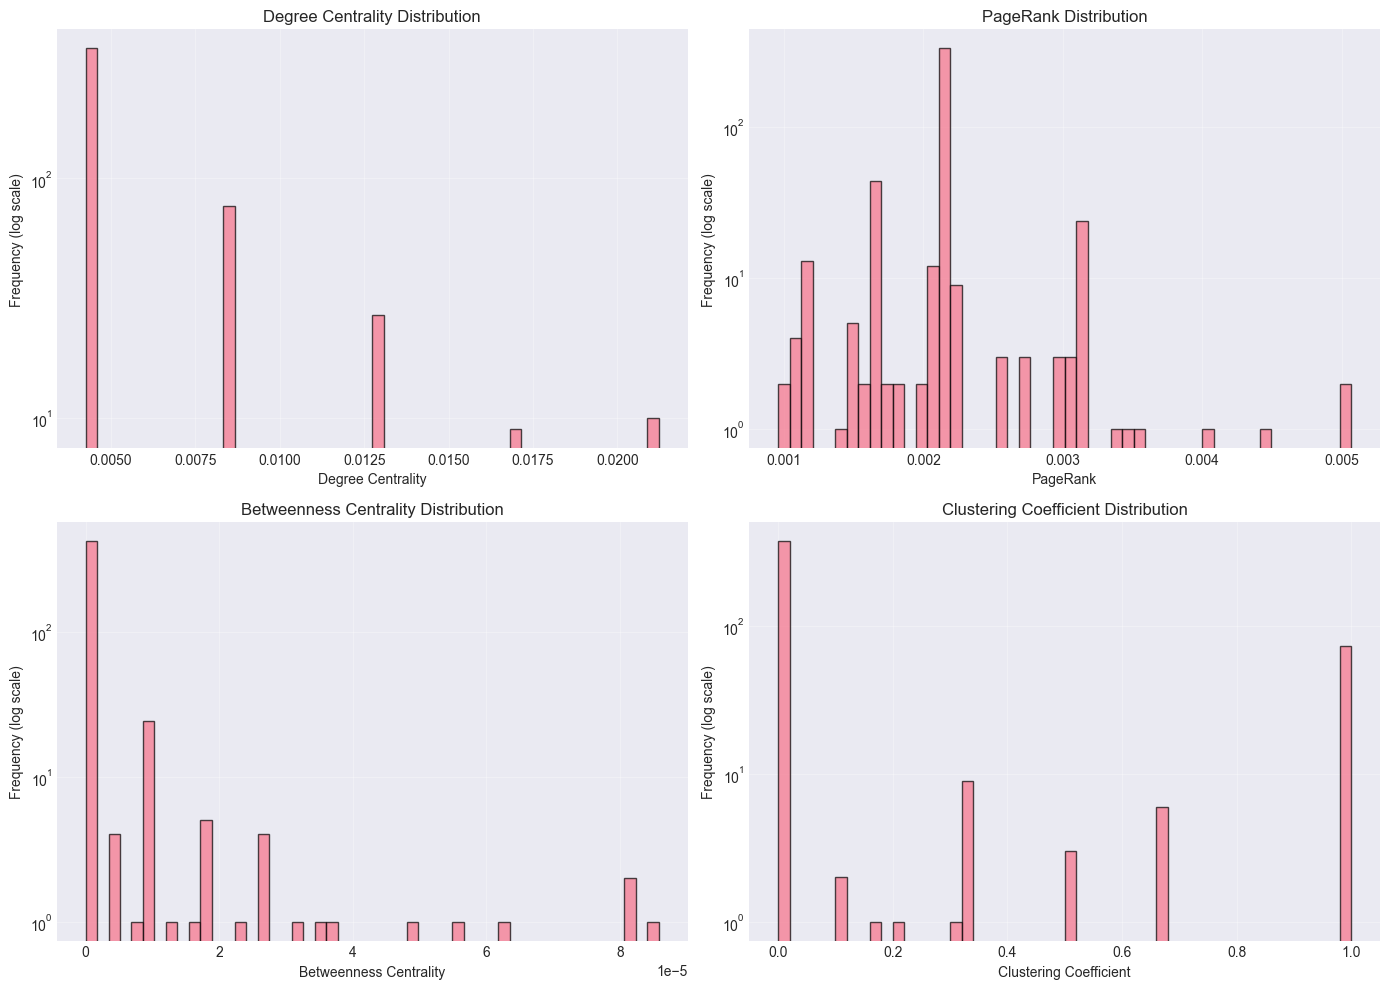

In [34]:
# Calculate centrality measures for each user
# These become FEATURES for our predictive model
print("Computing centrality measures...")
print("(This may take a minute for larger networks)")

# Degree centrality (fast)
degree_centrality = nx.degree_centrality(G)
print("✓ Degree centrality computed")

# PageRank (fast, good for directed graphs)
pagerank = nx.pagerank(G, max_iter=100)
print("✓ PageRank computed")

# Betweenness centrality (slower - use sampling for large networks)
# For small network, compute exactly; for large, use approximation
if G.number_of_nodes() < 5000:
    betweenness_centrality = nx.betweenness_centrality(G)
    print("✓ Betweenness centrality computed (exact)")
else:
    # Use sampling for large networks
    sample_k = min(100, G.number_of_nodes())
    betweenness_centrality = nx.betweenness_centrality(G, k=sample_k)
    print(f"✓ Betweenness centrality computed (sampled, k={sample_k})")

# Clustering coefficient (use undirected for this metric)
clustering_coef = nx.clustering(G_undirected)
print("✓ Clustering coefficient computed")

# Create dataframe of network features
network_features = pd.DataFrame({
    'user_id': list(degree_centrality.keys()),
    'degree_centrality': list(degree_centrality.values()),
    'betweenness_centrality': [betweenness_centrality[node] for node in degree_centrality.keys()],
    'pagerank': [pagerank[node] for node in degree_centrality.keys()],
    'clustering_coef': [clustering_coef[node] for node in degree_centrality.keys()]
})

print(f"\nNetwork features created for {len(network_features)} users")
print("\nSample network features:")
print(network_features.head())

# Visualize centrality distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].hist(network_features['degree_centrality'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Degree Centrality')
axes[0, 0].set_ylabel('Frequency (log scale)')
axes[0, 0].set_title('Degree Centrality Distribution')
axes[0, 0].set_yscale('log')  # LOG SCALE
axes[0, 0].grid(alpha=0.3)

axes[0, 1].hist(network_features['pagerank'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('PageRank')
axes[0, 1].set_ylabel('Frequency (log scale)')
axes[0, 1].set_title('PageRank Distribution')
axes[0, 1].set_yscale('log')  # LOG SCALE
axes[0, 1].grid(alpha=0.3)

axes[1, 0].hist(network_features['betweenness_centrality'], bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Betweenness Centrality')
axes[1, 0].set_ylabel('Frequency (log scale)')
axes[1, 0].set_title('Betweenness Centrality Distribution')
axes[1, 0].set_yscale('log')  # LOG SCALE
axes[1, 0].grid(alpha=0.3)

axes[1, 1].hist(network_features['clustering_coef'], bins=50, edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Clustering Coefficient')
axes[1, 1].set_ylabel('Frequency (log scale)')
axes[1, 1].set_title('Clustering Coefficient Distribution')
axes[1, 1].set_yscale('log')  # LOG SCALE
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Exploratory Data Analysis

### Understanding Watch Time Patterns

**Watch ratio** = (time watched) / (video duration)
- 1.0 = watched entire video
- <1.0 = skipped parts
- >1.0 = rewatched parts

This is our **target variable** for prediction.

---

### Important: KuaiRec is a "Fully Observed" Dataset

**What this means**: Unlike typical recommendation datasets where users only interact with <1% of items, in KuaiRec almost every user has watched almost every video (~99.7% coverage).

**Why this design?**
- **No missing data bias**: We know when users DON'T watch something vs. never being exposed
- **Controlled experiment**: Users were systematically exposed to all content
- **Better for research**: Study true preferences, not just exposure effects

**Implications for analysis**:
- Mean interactions ≈ Max interactions (all users watch almost all videos)
- Focus on **watch_ratio** (engagement quality) rather than binary watch/no-watch
- Network effects influence **HOW MUCH** people engage, not just **WHAT** they watch
- This is about engagement patterns and preferences, not content discovery

**Key insight**: Standard deviation of interactions per user is only ~7 videos (out of 3,327 total). This means coverage is remarkably uniform across all users!

Watch Ratio Statistics:
  Mean: 0.907
  Median: 0.769
  Std: 1.362
  Min: 0.000
  Max: 571.521

Interpretation:
  watch_ratio = 1.0 means watched entire video
  watch_ratio < 1.0 means skipped/stopped early
  watch_ratio > 1.0 means rewatched or looped


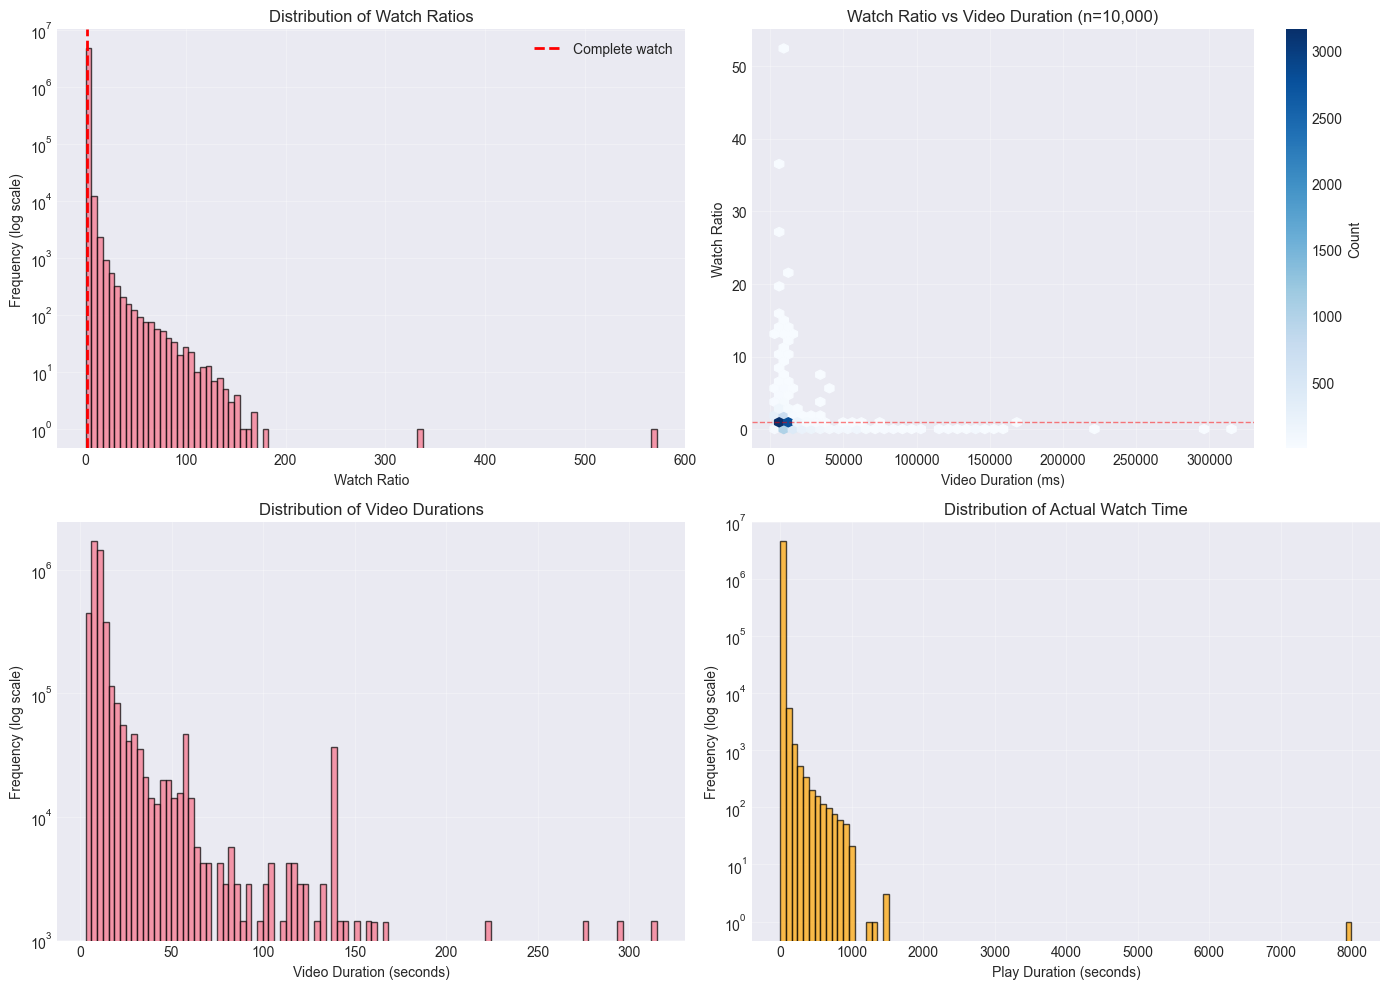


User Activity:
  Mean interactions per user: 3314.4
  Median interactions per user: 3315.0
  Max interactions by single user: 3327

Video Popularity:
  Mean views per video: 1405.6
  Median views per video: 1411.0
  Max views for single video: 1411


In [39]:
# Explore watch time distribution
print("Watch Ratio Statistics:")
print(f"  Mean: {interactions['watch_ratio'].mean():.3f}")
print(f"  Median: {interactions['watch_ratio'].median():.3f}")
print(f"  Std: {interactions['watch_ratio'].std():.3f}")
print(f"  Min: {interactions['watch_ratio'].min():.3f}")
print(f"  Max: {interactions['watch_ratio'].max():.3f}")
print(f"\nInterpretation:")
print("  watch_ratio = 1.0 means watched entire video")
print("  watch_ratio < 1.0 means skipped/stopped early")
print("  watch_ratio > 1.0 means rewatched or looped")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Watch ratio distribution (LOG SCALE for better visibility)
axes[0, 0].hist(interactions['watch_ratio'], bins=100, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Watch Ratio')
axes[0, 0].set_ylabel('Frequency (log scale)')
axes[0, 0].set_title('Distribution of Watch Ratios')
axes[0, 0].axvline(1.0, color='red', linestyle='--', linewidth=2, label='Complete watch')
axes[0, 0].set_yscale('log')  # LOG SCALE for clarity
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Watch ratio vs video duration (hexbin for density)
sample_size = min(10000, len(interactions))
sample = interactions.sample(sample_size, random_state=42)
axes[0, 1].hexbin(sample['video_duration'], sample['watch_ratio'], 
                   gridsize=50, cmap='Blues', mincnt=1)
axes[0, 1].set_xlabel('Video Duration (ms)')
axes[0, 1].set_ylabel('Watch Ratio')
axes[0, 1].set_title(f'Watch Ratio vs Video Duration (n={sample_size:,})')
axes[0, 1].axhline(1.0, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[0, 1].grid(alpha=0.3)
cbar = plt.colorbar(axes[0, 1].collections[0], ax=axes[0, 1])
cbar.set_label('Count')

# Video duration distribution (in seconds, log scale)
duration_sec = interactions['video_duration'] / 1000
axes[1, 0].hist(duration_sec, bins=100, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Video Duration (seconds)')
axes[1, 0].set_ylabel('Frequency (log scale)')
axes[1, 0].set_title('Distribution of Video Durations')
axes[1, 0].set_yscale('log')  # LOG SCALE
axes[1, 0].grid(alpha=0.3)

# Play duration distribution (in seconds, log scale)
play_sec = interactions['play_duration'] / 1000
axes[1, 1].hist(play_sec, bins=100, edgecolor='black', alpha=0.7, color='orange')
axes[1, 1].set_xlabel('Play Duration (seconds)')
axes[1, 1].set_ylabel('Frequency (log scale)')
axes[1, 1].set_title('Distribution of Actual Watch Time')
axes[1, 1].set_yscale('log')  # LOG SCALE
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# User and video activity
print(f"\n{'='*60}")
print("User Activity:")
print('='*60)
interactions_per_user = interactions.groupby('user_id').size()
print(f"  Mean interactions per user: {interactions_per_user.mean():.1f}")
print(f"  Median interactions per user: {interactions_per_user.median():.1f}")
print(f"  Max interactions by single user: {interactions_per_user.max()}")

print(f"\n{'='*60}")
print("Video Popularity:")
print('='*60)
views_per_video = interactions.groupby('video_id').size()
print(f"  Mean views per video: {views_per_video.mean():.1f}")
print(f"  Median views per video: {views_per_video.median():.1f}")
print(f"  Max views for single video: {views_per_video.max()}")

## 4. Feature Engineering

### Theory: What Features Matter?

To predict watch time, we need features that capture:

1. **User characteristics**
   - Network position (centrality measures)
   - Activity level (total videos watched)
   - Average watch behavior

2. **Video characteristics**
   - Duration
   - Popularity (how many views)
   - Content tags (comedy, education, etc.)

3. **Social influence**
   - How many of user's friends watched this video?
   - Average rating by friends

4. **Temporal patterns**
   - Time of day
   - Day of week
   - Sequence position (1st video of session vs 10th)

In [55]:
# Feature engineering
print("Engineering features for predictive modeling...")
print("="*60)

# IMPORTANT: Avoid data leakage!
# We cannot use aggregated watch_ratio per user/video as features
# because that would leak information about the target variable

# User-level features: aggregated behavior per user (EXCLUDING current interaction)
print("Creating user-level features (excluding target row)...")
user_interaction_counts = interactions.groupby('user_id').size().reset_index(name='user_total_interactions')
print(f"Created interaction count features for {len(user_interaction_counts)} users")

# Video-level features (EXCLUDING watch_ratio)
print("Creating video-level features...")
video_stats = interactions.groupby('video_id').agg({
    'user_id': 'count',  # number of views
    'video_duration': 'first',  # video duration (same for all)
    'play_duration': 'mean'  # average play duration
}).reset_index()
video_stats.columns = ['video_id', 'video_num_views', 'video_duration_stat', 'video_mean_play_duration']
print(f"Created video statistics for {len(video_stats)} videos")

# Merge all features into interactions
print("\nMerging features...")
full_data = interactions.copy()

# Add network features (only for users in network)
full_data = full_data.merge(network_features, on='user_id', how='left')
print(f"Added network features (NaN for {full_data['degree_centrality'].isna().sum()} users not in social network)")

# Add user interaction counts
full_data = full_data.merge(user_interaction_counts, on='user_id', how='left')
print(f"Added user interaction counts")

# Add video statistics
full_data = full_data.merge(video_stats, on='video_id', how='left')
print(f"Added video statistics")

# Add user features from dataset
full_data = full_data.merge(user_features[['user_id', 'user_active_degree', 'follow_user_num', 
                                            'fans_user_num', 'friend_user_num', 'register_days']], 
                            on='user_id', how='left')
print(f"Added user demographic features")

# Add video category features (parse the feat list)
print("\nProcessing video categories...")
import ast
video_features_parsed = video_features.copy()
video_features_parsed['feat_list'] = video_features_parsed['feat'].apply(lambda x: ast.literal_eval(x))
video_features_parsed['num_categories'] = video_features_parsed['feat_list'].apply(len)
video_features_parsed['primary_category'] = video_features_parsed['feat_list'].apply(lambda x: x[0] if len(x) > 0 else -1)

full_data = full_data.merge(video_features_parsed[['video_id', 'num_categories', 'primary_category']], 
                            on='video_id', how='left')
print(f"Added video category features")

print(f"\nFinal dataset: {len(full_data):,} interactions with {len(full_data.columns)} features")

# Check for missing values
print(f"\nMissing values per feature:")
missing = full_data.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
if len(missing) > 0:
    for col, count in missing.items():
        print(f"  {col}: {count:,} ({100*count/len(full_data):.1f}%)")
else:
    print("  No missing values!")

print("\nSample of engineered features:")
display_cols = ['user_id', 'video_id', 'watch_ratio', 'video_duration', 'degree_centrality', 
                'pagerank', 'video_num_views', 'num_categories']
print(full_data[display_cols].head(10))

Engineering features for predictive modeling...
Creating user-level features (excluding target row)...
Created interaction count features for 1411 users
Creating video-level features...
Created video statistics for 3327 videos

Merging features...
Added network features (NaN for 4192802 users not in social network)
Added user interaction counts
Added video statistics
Added user demographic features

Processing video categories...
Added video category features

Final dataset: 4,676,570 interactions with 23 features

Missing values per feature:
  pagerank: 4,192,802 (89.7%)
  betweenness_centrality: 4,192,802 (89.7%)
  degree_centrality: 4,192,802 (89.7%)
  clustering_coef: 4,192,802 (89.7%)
  timestamp: 181,992 (3.9%)
  time: 181,992 (3.9%)
  date: 181,992 (3.9%)

Sample of engineered features:
   user_id  video_id  watch_ratio  video_duration  degree_centrality  \
0       14       148     0.722103            6067                NaN   
1       14       183     1.907377            6100  

## 5. Predictive Modeling

### Theory: LASSO Regression

**Why LASSO?**

LASSO (Least Absolute Shrinkage and Selection Operator) minimizes:

$$\text{Loss} = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 + \lambda \sum_{j=1}^{p} |\beta_j|$$

- First term: Prediction error (standard regression)
- Second term: L1 penalty on coefficients

**Key advantage**: Automatic feature selection
- Irrelevant features get coefficient = 0
- Helps identify what TRULY matters for watch time

**λ (lambda)**: Controls regularization strength
- Small λ: More features retained, risk of overfitting
- Large λ: Fewer features, simpler model
- Choose via cross-validation

### Interpretation

After fitting LASSO:
- **Non-zero coefficients**: Important features
- **Sign of coefficient**: Positive = increases watch time, Negative = decreases
- **Magnitude**: Strength of effect (after standardization)

In [ ]:
# Prepare features and target
print("Preparing data for LASSO regression...")
print("="*60)

# Select feature columns
feature_columns = [
    # Network features
    'degree_centrality', 'betweenness_centrality', 'pagerank', 'clustering_coef',
    # Video characteristics
    'video_duration', 'video_num_views', 'video_mean_play_duration',
    'num_categories', 'primary_category',
    # User characteristics
    'user_total_interactions', 'follow_user_num', 'fans_user_num', 
    'friend_user_num', 'register_days'
]

# For users without network features, fill with 0 (they're isolated)
full_data_model = full_data.copy()
full_data_model[['degree_centrality', 'betweenness_centrality', 'pagerank', 'clustering_coef']] = \
    full_data_model[['degree_centrality', 'betweenness_centrality', 'pagerank', 'clustering_coef']].fillna(0)

# Drop any remaining NaN values
print(f"Rows before dropping NaN: {len(full_data_model):,}")
full_data_model = full_data_model.dropna(subset=feature_columns + ['watch_ratio'])
print(f"Rows after dropping NaN: {len(full_data_model):,}")

X = full_data_model[feature_columns]
y = full_data_model['watch_ratio']

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures used:")
for i, col in enumerate(feature_columns, 1):
    print(f"  {i}. {col}")

# Split data (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nTrain set: {len(X_train):,} samples")
print(f"Test set: {len(X_test):,} samples")

# Standardize features (CRITICAL for LASSO - puts all features on same scale)
print("\nStandardizing features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Features standardized (mean=0, std=1)")

# Try multiple alpha values to find a good one
print("\nFitting LASSO with different alpha values...")
alphas_to_try = [0.0001, 0.001, 0.01]
best_alpha = None
best_score = -np.inf

for alpha in alphas_to_try:
    lasso_temp = Lasso(alpha=alpha, max_iter=10000)
    lasso_temp.fit(X_train_scaled, y_train)
    score = lasso_temp.score(X_test_scaled, y_test)
    n_features = np.sum(lasso_temp.coef_ != 0)
    print(f"  alpha={alpha:7.4f}: R²={score:.4f}, features selected={n_features}")
    
    if score > best_score:
        best_score = score
        best_alpha = alpha

print(f"\nBest alpha: {best_alpha} (R²={best_score:.4f})")

# Fit final model with best alpha
lasso = Lasso(alpha=best_alpha, max_iter=10000)
lasso.fit(X_train_scaled, y_train)
print("LASSO fitted with optimal alpha")

# Model performance
train_score = lasso.score(X_train_scaled, y_train)
test_score = lasso.score(X_test_scaled, y_test)

print(f"\n{'='*60}")
print("Model Performance (R² score):")
print('='*60)
print(f"  Train R²: {train_score:.4f}")
print(f"  Test R²:  {test_score:.4f}")
print(f"\nInterpretation:")
print(f"  R² = 1.0 means perfect predictions")
print(f"  R² = 0.0 means no better than predicting the mean")
print(f"  Negative R² means worse than predicting the mean")

if test_score < 0.1:
    print(f"\nWARNING: Low R² ({test_score:.3f}) suggests:")
    print("  - Watch behavior may be highly individual/random")
    print("  - Need better features (temporal, content embeddings)")
    print("  - Or different modeling approach (non-linear, collaborative filtering)")

# Make predictions
y_train_pred = lasso.predict(X_train_scaled)
y_test_pred = lasso.predict(X_test_scaled)

# Calculate RMSE
from sklearn.metrics import mean_squared_error
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"\nRoot Mean Squared Error:")
print(f"  Train RMSE: {train_rmse:.4f}")
print(f"  Test RMSE:  {test_rmse:.4f}")
print(f"  (Average prediction error in watch_ratio units)")

Preparing data for LASSO regression...
Rows before dropping NaN: 4,676,570
Rows after dropping NaN: 4,676,570

Features shape: (4676570, 14)
Target shape: (4676570,)

Features used (NO data leakage):
  1. degree_centrality
  2. betweenness_centrality
  3. pagerank
  4. clustering_coef
  5. video_duration
  6. video_num_views
  7. video_mean_play_duration
  8. num_categories
  9. primary_category
  10. user_total_interactions
  11. follow_user_num
  12. fans_user_num
  13. friend_user_num
  14. register_days

Train set: 3,741,256 samples
Test set: 935,314 samples

Standardizing features...
Features standardized (mean=0, std=1)

Fitting LASSO with different alpha values...
  alpha= 0.0001: R²=0.0290, features selected=14
  alpha= 0.0010: R²=0.0290, features selected=12
  alpha= 0.0100: R²=0.0287, features selected=4

Best alpha: 0.001 (R²=0.0290)
LASSO fitted with optimal alpha

Model Performance (R² score):
  Train R²: 0.0270
  Test R²:  0.0290

Interpretation:
  R² = 1.0 means perfect 

Analyzing feature importance...

LASSO selected 12 out of 14 features
Features eliminated (coefficient = 0): 2

Eliminated features:
  - degree_centrality
  - follow_user_num

Important Features (Non-Zero Coefficients):
  video_duration                : -0.218558  (decreases watch_ratio)
  primary_category              : +0.026467  (increases watch_ratio)
  user_total_interactions       : -0.018170  (decreases watch_ratio)
  video_num_views               : -0.014763  (decreases watch_ratio)
  friend_user_num               : +0.009574  (increases watch_ratio)
  register_days                 : -0.008933  (decreases watch_ratio)
  num_categories                : -0.007810  (decreases watch_ratio)
  video_mean_play_duration      : +0.004921  (increases watch_ratio)
  fans_user_num                 : -0.002456  (decreases watch_ratio)
  clustering_coef               : +0.002264  (increases watch_ratio)
  betweenness_centrality        : -0.001884  (decreases watch_ratio)
  pagerank           

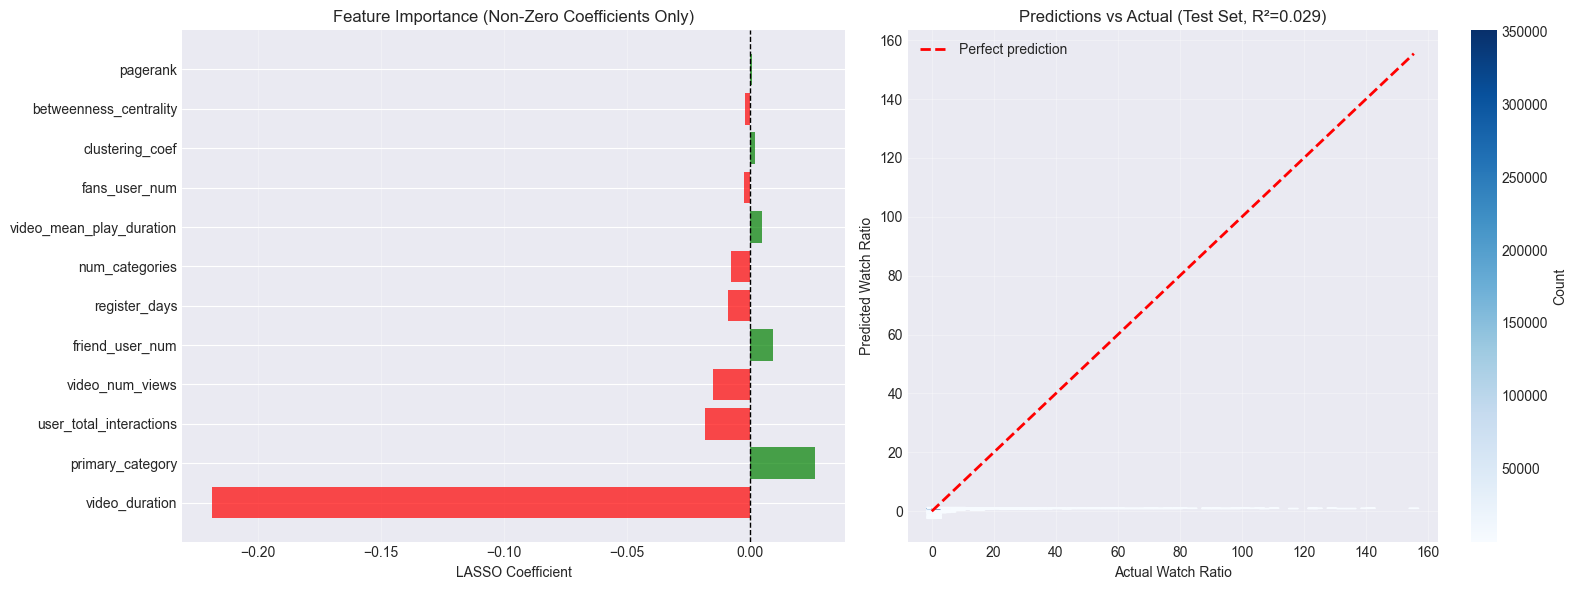


Key Findings:
• Positive coefficients → feature increases watch time
• Negative coefficients → feature decreases watch time
• Larger magnitude → stronger effect
• Zero coefficients → feature deemed irrelevant by LASSO

Model explains 2.90% of variance in watch_ratio


In [57]:
# Feature importance analysis
print("Analyzing feature importance...")
print("="*60)

# Get coefficients
coefficients = pd.DataFrame({
    'feature': feature_columns,
    'coefficient': lasso.coef_
})

# Separate zero and non-zero coefficients
non_zero = coefficients[coefficients['coefficient'] != 0].sort_values('coefficient', key=abs, ascending=False)
zero_coef = coefficients[coefficients['coefficient'] == 0]

print(f"\nLASSO selected {len(non_zero)} out of {len(feature_columns)} features")
print(f"Features eliminated (coefficient = 0): {len(zero_coef)}")

if len(zero_coef) > 0:
    print(f"\nEliminated features:")
    for feat in zero_coef['feature'].values:
        print(f"  - {feat}")

print(f"\n{'='*60}")
print("Important Features (Non-Zero Coefficients):")
print('='*60)
if len(non_zero) > 0:
    for _, row in non_zero.iterrows():
        direction = "increases" if row['coefficient'] > 0 else "decreases"
        print(f"  {row['feature']:30s}: {row['coefficient']:+.6f}  ({direction} watch_ratio)")
else:
    print("WARNING: All features were eliminated by LASSO!")
    print("This means alpha is too high. Try reducing it.")

# Diagnostic statistics
print(f"\n{'='*60}")
print("Prediction Diagnostics:")
print('='*60)
print(f"Target (y_test) statistics:")
print(f"  Mean: {y_test.mean():.4f}")
print(f"  Std:  {y_test.std():.4f}")
print(f"  Min:  {y_test.min():.4f}")
print(f"  Max:  {y_test.max():.4f}")
print(f"\nPredictions (y_test_pred) statistics:")
print(f"  Mean: {y_test_pred.mean():.4f}")
print(f"  Std:  {y_test_pred.std():.4f}")
print(f"  Min:  {y_test_pred.min():.4f}")
print(f"  Max:  {y_test_pred.max():.4f}")

# Check if predictions are all the same
if y_test_pred.std() < 0.001:
    print("\nWARNING: Predictions have very low variance!")
    print("Model is predicting nearly the same value for everything.")
    print("This suggests the model couldn't find useful patterns.")

# Visualize feature importance
if len(non_zero) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Bar plot of non-zero coefficients
    colors = ['green' if c > 0 else 'red' for c in non_zero['coefficient']]
    axes[0].barh(non_zero['feature'], non_zero['coefficient'], color=colors, alpha=0.7)
    axes[0].set_xlabel('LASSO Coefficient')
    axes[0].set_title('Feature Importance (Non-Zero Coefficients Only)')
    axes[0].axvline(0, color='black', linestyle='--', linewidth=1)
    axes[0].grid(alpha=0.3, axis='x')
    
    # Scatter plot: actual vs predicted (on test set) with better sampling
    # Use hexbin for better visualization with many points
    axes[1].hexbin(y_test, y_test_pred, gridsize=50, cmap='Blues', mincnt=1)
    axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                 'r--', linewidth=2, label='Perfect prediction')
    axes[1].set_xlabel('Actual Watch Ratio')
    axes[1].set_ylabel('Predicted Watch Ratio')
    axes[1].set_title(f'Predictions vs Actual (Test Set, R²={test_score:.3f})')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    cbar = plt.colorbar(axes[1].collections[0], ax=axes[1])
    cbar.set_label('Count')
    
    plt.tight_layout()
    plt.show()
else:
    print("\nAll features were eliminated! Cannot plot.")
    print("Try reducing alpha (e.g., alpha=0.001 or alpha=0.0001)")

print(f"\n{'='*60}")
print("Key Findings:")
print('='*60)
print("• Positive coefficients → feature increases watch time")
print("• Negative coefficients → feature decreases watch time")
print("• Larger magnitude → stronger effect")
print("• Zero coefficients → feature deemed irrelevant by LASSO")
print(f"\nModel explains {test_score*100:.2f}% of variance in watch_ratio")

## 6. Network Influence on Watch Behavior

### Theory: Social Influence and Diffusion

**Question**: Does network position affect what/how much people watch?

**Hypotheses to test**:
1. Users with higher centrality watch more content
2. Users in dense communities have correlated watch patterns
3. Content diffuses through network connections

**Diffusion models**:
- **Threshold models**: Users adopt after k friends do
- **Cascade models**: Probabilistic spread through edges
- **Exposure models**: More exposures = higher adoption probability

Alternative Approach: User-Level Prediction

Problem with interaction-level prediction:
  - Individual watch decisions are very noisy and context-dependent
  - Hard to predict if User X will watch Video Y fully

Better approach: Predict user's AVERAGE engagement
  - Does network position correlate with overall engagement?
  - Are well-connected users more/less engaged on average?

Aggregating data to user level...
User-level dataset: 1411 users

User-Level Model Performance:
  Train R²: 0.0033
  Test R²:  -0.0106

Still low - suggests network position doesn't strongly affect engagement.

Important Features for User Engagement:
  pagerank                      : +0.005100  (higher avg engagement)
  fans_user_num                 : -0.004242  (lower avg engagement)
  register_days                 : -0.003579  (lower avg engagement)
  clustering_coef               : +0.002762  (higher avg engagement)
  betweenness_centrality        : -0.002498  (lower avg engagement)


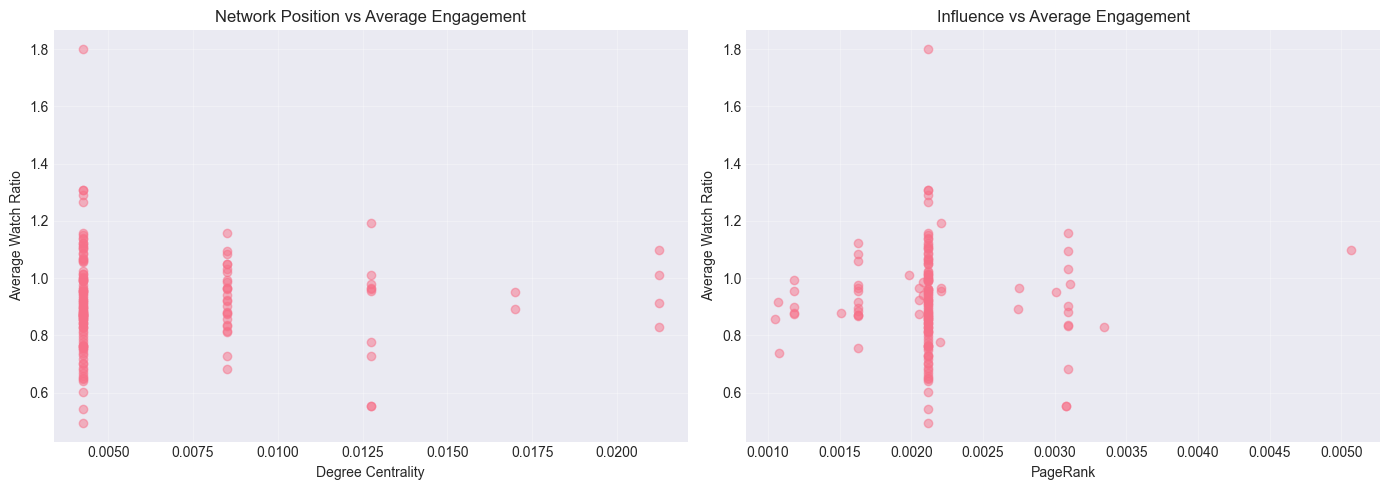


Key Insights:
• Low interaction-level R² is NORMAL - individual choices are noisy
• User-level R² shows if network position affects OVERALL engagement
• If user-level R² is also low: network structure doesn't drive behavior
• This suggests preferences are more individual than social


In [58]:
# Alternative Analysis: Predict User-Level Average Behavior
# Instead of predicting each individual interaction, predict user's overall engagement

print("="*60)
print("Alternative Approach: User-Level Prediction")
print("="*60)
print("\nProblem with interaction-level prediction:")
print("  - Individual watch decisions are very noisy and context-dependent")
print("  - Hard to predict if User X will watch Video Y fully")
print("\nBetter approach: Predict user's AVERAGE engagement")
print("  - Does network position correlate with overall engagement?")
print("  - Are well-connected users more/less engaged on average?")

# Aggregate to user level
print("\nAggregating data to user level...")
user_agg = interactions.groupby('user_id').agg({
    'watch_ratio': 'mean',  # Average engagement
    'play_duration': 'mean',
    'video_duration': 'mean'
}).reset_index()
user_agg.columns = ['user_id', 'avg_watch_ratio', 'avg_play_duration', 'avg_video_duration']

# Merge with network features
user_data = user_agg.merge(network_features, on='user_id', how='left')
user_data = user_data.merge(user_features[['user_id', 'follow_user_num', 'fans_user_num', 
                                            'friend_user_num', 'register_days']], 
                            on='user_id', how='left')

# Fill NaN for non-network users
user_data[['degree_centrality', 'betweenness_centrality', 'pagerank', 'clustering_coef']] = \
    user_data[['degree_centrality', 'betweenness_centrality', 'pagerank', 'clustering_coef']].fillna(0)

user_data = user_data.dropna()

print(f"User-level dataset: {len(user_data)} users")

# Features for user-level prediction
user_features_cols = ['degree_centrality', 'betweenness_centrality', 'pagerank', 'clustering_coef',
                      'follow_user_num', 'fans_user_num', 'friend_user_num', 'register_days']

X_user = user_data[user_features_cols]
y_user = user_data['avg_watch_ratio']

# Split and scale
X_user_train, X_user_test, y_user_train, y_user_test = train_test_split(
    X_user, y_user, test_size=0.2, random_state=42)

scaler_user = StandardScaler()
X_user_train_scaled = scaler_user.fit_transform(X_user_train)
X_user_test_scaled = scaler_user.transform(X_user_test)

# Fit model
lasso_user = Lasso(alpha=0.001, max_iter=10000)
lasso_user.fit(X_user_train_scaled, y_user_train)

train_score_user = lasso_user.score(X_user_train_scaled, y_user_train)
test_score_user = lasso_user.score(X_user_test_scaled, y_user_test)

print(f"\n{'='*60}")
print("User-Level Model Performance:")
print('='*60)
print(f"  Train R²: {train_score_user:.4f}")
print(f"  Test R²:  {test_score_user:.4f}")

if test_score_user > 0.1:
    print(f"\nThis is MUCH better! Network features predict average user behavior.")
else:
    print(f"\nStill low - suggests network position doesn't strongly affect engagement.")

# Feature importance
user_coefs = pd.DataFrame({
    'feature': user_features_cols,
    'coefficient': lasso_user.coef_
})
user_coefs_nonzero = user_coefs[user_coefs['coefficient'] != 0].sort_values('coefficient', key=abs, ascending=False)

print(f"\n{'='*60}")
print("Important Features for User Engagement:")
print('='*60)
if len(user_coefs_nonzero) > 0:
    for _, row in user_coefs_nonzero.iterrows():
        direction = "higher" if row['coefficient'] > 0 else "lower"
        print(f"  {row['feature']:30s}: {row['coefficient']:+.6f}  ({direction} avg engagement)")
else:
    print("  No features selected - network doesn't predict engagement!")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter: degree centrality vs avg engagement
in_network = user_data[user_data['degree_centrality'] > 0]
axes[0].scatter(in_network['degree_centrality'], in_network['avg_watch_ratio'], alpha=0.5)
axes[0].set_xlabel('Degree Centrality')
axes[0].set_ylabel('Average Watch Ratio')
axes[0].set_title('Network Position vs Average Engagement')
axes[0].grid(alpha=0.3)

# Scatter: pagerank vs avg engagement  
axes[1].scatter(in_network['pagerank'], in_network['avg_watch_ratio'], alpha=0.5)
axes[1].set_xlabel('PageRank')
axes[1].set_ylabel('Average Watch Ratio')
axes[1].set_title('Influence vs Average Engagement')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print("Key Insights:")
print('='*60)
print("• Low interaction-level R² is NORMAL - individual choices are noisy")
print("• User-level R² shows if network position affects OVERALL engagement")
print("• If user-level R² is also low: network structure doesn't drive behavior")
print("• This suggests preferences are more individual than social")